# Statistics for each month in the study area

The purpose of this code is to retrieve Sentinel 2 images for Samos Island, Greece, and calculate indexes for this area for several months to have statistics. Then, weather data is retrieved, correlations are exposed and statistical tests are performed. A number of different plots are also displayed to see the evolution in the area.

By Michel Tarby

### Packages importations 

In [7]:
import importlib
import sys
import subprocess
import os
import earthpy.plot as ep
import pandas as pd
import matplotlib.patches as patches
import numpy as np
import seaborn as sns
import geemap.common as com
import scipy as sp
import scikit_posthocs as sph
import math
import matplotlib.pyplot as plt
from meteostat import Point, Monthly

def install_and_import(package):
    try:
        importlib.import_module(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    finally:
        globals()[package] = importlib.import_module(package)

packages = ['ee', 'geemap', 'rasterio', 'rasterstats', 'geopandas', 'numpy', 'scipy', 'matplotlib']

for package in packages:
    install_and_import(package)

# Additional imports
from scipy.optimize import curve_fit
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import kruskal
from scipy.stats import levene
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from datetime import datetime
from meteostat import Point, Monthly

In [8]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

### Map instance with a zoom on Psili Ammos area

In [9]:
# Create a geemap Map instance
Map = geemap.Map()

# Define the coordinates and zoom level for the region of interest (ROI) - (Samos, in this case)
roi_longitude = 27.009654
roi_latitude = 37.707147
zoom_level = 15

# Center the map on the ROI 
Map.setCenter(roi_longitude, roi_latitude, zoom_level)

# Display the map
Map

Map(center=[37.707147, 27.009654], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox…

### Retrieve Sentinel 2 Images and put shape of Psili Ammos on top

In [10]:
# Function to mask clouds in Sentinel-2 images
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

# Define the study area and date range
study_area = ee.Geometry.Point(roi_longitude, roi_latitude)
start_date = '2023-05-01'
end_date = '2023-05-31'

# Load Sentinel-2 images and apply cloud masking, further we select only imagery with less than 5% cloud

dataset_image = (ee.ImageCollection('COPERNICUS/S2_SR')
                 .filterBounds(study_area)
                 .filterDate(start_date, end_date)
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))
                 .map(maskS2clouds))

# Define visualization parameters
visualization = {
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

# Add the Sentinel-2 image layer to the map
Map.addLayer(dataset_image, visualization, 'S2')

# Import delimitations of the wetland
samos_area = ee.FeatureCollection('projects/archipelagos-michel-project/assets/samos_area')
Map.addLayer(samos_area, {'color': 'purple'}, 'Delimitations Psili Ammos')
feature_geometry = samos_area.geometry() #delimitations to clip NDVI and NDWI

print('Image collection size:', dataset_image.size().getInfo())
sample_image = dataset_image.first()  # Get the first image from the collection
band_names = sample_image.bandNames().getInfo()
print('Sample image band names:', band_names)

Image collection size: 1
Sample image band names: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']


### Creation of beginning date and ending date for each month for the considerate period

In [11]:
# End and begin dates for median creation
date_range = pd.date_range('2018-01-01', '2022-12-31', freq='MS')

begin_date = date_range.strftime("%Y-%m-%d")
end_date = (date_range + MonthEnd(1)).strftime("%Y-%m-%d")

### Creation of median images and then NDVI for each month

In [12]:
# Iterate over each month
median_images = []
NDVI_month = []
NDWI_month = []
SWI_month = []
SAVI_month = []

for i in range(len(begin_date)):
    month_start = begin_date[i]
    month_end = end_date[i]
    month_images = (ee.ImageCollection('COPERNICUS/S2_SR')
                 .filterBounds(study_area)
                 .filterDate(month_start, month_end)
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))
                 .map(maskS2clouds))
    month_median = month_images.median()
    
    # If there is no images with less than 5% cloud, then we try to have other with at max 20%
    if month_median.bandNames().size().eq(0):
        month_images = (ee.ImageCollection('COPERNICUS/S2_SR')
                 .select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12','QA60')
                 .filterBounds(study_area)
                 .filterDate(month_start, month_end)
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
                 .map(maskS2clouds))
        month_median = month_images.median()

    # Normalized difference is computed only once
    ndvi = month_median.normalizedDifference(['B8', 'B4'])
    ndwi = month_median.normalizedDifference(['B3', 'B8'])
    swi = month_median.normalizedDifference(['B5', 'B11'])
    savi = month_median.expression(
      '((B8 - B4) / (B8 + B4 + 0.428)) * 1.428',
      {
        'B8': month_median.select('B8'),
        'B4': month_median.select('B4')
      }
    )   

    masked_ndvi = ndvi.clip(feature_geometry)
    masked_ndwi = ndwi.clip(feature_geometry)
    masked_savi = savi.clip(feature_geometry)
    masked_swi = swi.clip(feature_geometry)
    
    median_images.append(month_median)
    NDVI_month.append(masked_ndvi)
    NDWI_month.append(masked_ndwi)
    SAVI_month.append(masked_savi)
    SWI_month.append(masked_swi)


### Visualization of one NDVI image to confirm results

In [13]:
# Select the NDVI image for a specific month (e.g., month 1)
ndvi_image = NDWI_month[8]

# Define visualization parameters for the NDVI
ndvi_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'yellow', 'green']
}

# Add the NDVI image to the GEE map
Map.addLayer(ndvi_image, ndvi_vis_params, 'NDVI Image')
Map

Map(bottom=3244669.0, center=[37.707147, 27.009654], controls=(WidgetControl(options=['position', 'transparent…

In [14]:
# Check if there are different median images in the list
unique_median_images = set(median_images)

if len(unique_median_images) == len(median_images):
    print("All median images are different.")
else:
    print("There are duplicate median images.")

# Print the number of unique median images
print("Number of unique median images:", len(unique_median_images))

All median images are different.
Number of unique median images: 60


In [15]:
print(median_images[1].bandNames().getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'QA60']


### NDVI Statistics calculation and plot

In [16]:
# Initialize lists to store the statistics
mean_ndvi = []
median_ndvi = []

# Compute NDVI statistics for each month
for ndvi_image in NDVI_month:
    # Compute mean NDVI
    mean = ndvi_image.reduceRegion(reducer=ee.Reducer.mean(), geometry=feature_geometry, scale=10).get('nd').getInfo()
    mean_ndvi.append(mean)
    
    # Compute median NDVI
    median = ndvi_image.reduceRegion(reducer=ee.Reducer.median(), geometry=feature_geometry, scale=10).get('nd').getInfo()
    median_ndvi.append(median)

In [17]:
# Create lists for mean comparision
def new_lists(entry):
    # Divide into 5 lists of 12 elements each
    divided_lists = [entry[i:i+12] for i in range(0, len(entry), 12)]
    
    # 12 lists of 5
    divided_lists_transposed = list(map(list, zip(*divided_lists)))
    
    # Return the divided and transposed lists
    return divided_lists, divided_lists_transposed

# Use function on mean ndvi
years_NDVI, months_NDVI = new_lists(mean_ndvi)


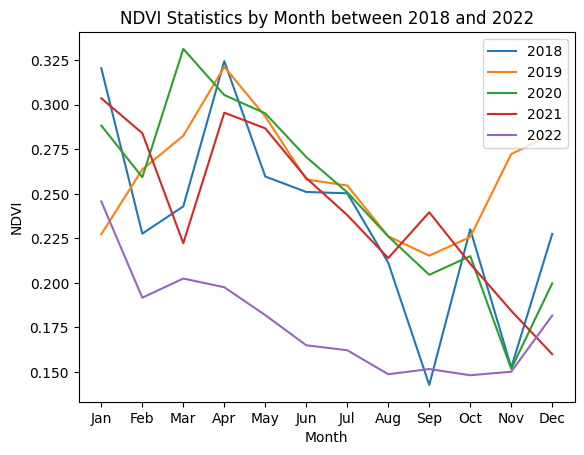

In [18]:
# Create x-axis labels using month names
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a list of x-coordinates for the plot
x = range(1, 13)

# Plot the divided lists
i=2018
for sublist in years_NDVI:
    plt.plot(x, sublist, label=str(i))
    i+=1
    
# Customize the plot
plt.xlabel('Month')
plt.ylabel('NDVI')
plt.title('NDVI Statistics by Month between 2018 and 2022')
plt.xticks(x, month_labels)
plt.legend()

# Display the plot
plt.show()


In [19]:
# Create x-axis labels using month names
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Repeat list to match data length
labels_repeated = month_labels * (round(len(mean_ndvi)/12))

# Create list to label data by year
end_year = 2022
years = [str(year) for year in range(2018, end_year + 1) for _ in range(12)]

# Create the Dataframe
data_NDVI = pd.DataFrame({'Year': years,
                          'Month': labels_repeated,
                          'Mean NDVI': mean_ndvi})

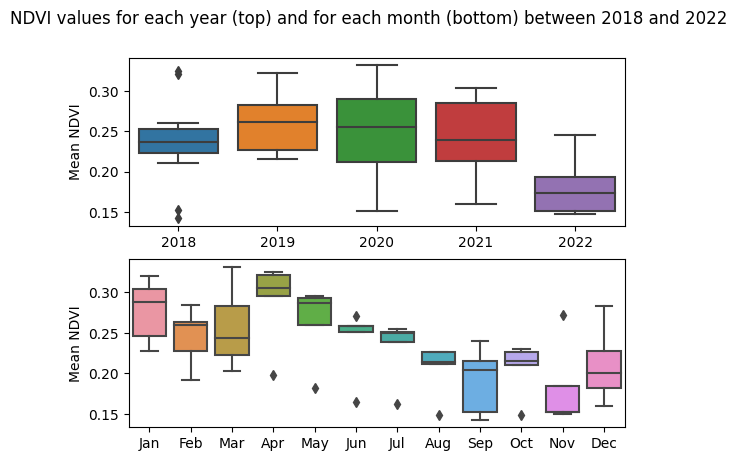

In [20]:
#define dimensions of subplots (rows, columns)
fig, axes = plt.subplots(2, 1)

#Create boxplot for year and month
sns.boxplot(data=data_NDVI, x='Year', y='Mean NDVI', ax=axes[0])
sns.boxplot(data=data_NDVI, x='Month', y='Mean NDVI', ax=axes[1])

# Disable x axis labels and add title
axes[0].set_xlabel('')
axes[1].set_xlabel('')
plt.suptitle('NDVI values for each year (top) and for each month (bottom) between 2018 and 2022', ha='center')

# Display the plot
plt.show()


### Function to test differences between means

In [22]:
# Statistical test mean differences from 2018 to 2022
def mean_difference(entry):
    stat_shap=[]
    p_shap=[]
    i=1
    a=0
    threshold = 0.05
    p_anova = p_kruskal = 0
    # Loop for Normality test
    for groups in entry:
        stat, p = shapiro(groups)
        stat_shap.append(stat)
        p_shap.append(p)
        i+=1
        if p<threshold:
            a=a
        else:
            a=1

    # If all groups follow a Normal distribution
    if a<1:
        print('All groups follow a Normal distribution')
        stat, p = levene(*entry)

        # Case when variances are not equal - Kruskal test
        if p < threshold:
            print("The groups do not have equal variances (heteroscedastic).")
            # Perform Kruskal-Wallis test
            stat, p_kruskal = kruskal(*entry)
            print('P-value for Kruskal test is :', p_kruskal)

        # Case when variances are equal - ANOVA test   
        else:
            print("The groups have equal variances (homoscedastic).")
            # Perform ANOVA test
            stat, p_anova = f_oneway(*entry)
            print('P-value for ANOVA test is :', p_anova)

    else:
        print('All groups do not follow a Normal distribution')
        stat, p_kruskal = kruskal(*entry)
        print('P-value for Kruskal test is :', p_kruskal)

    # Check if at least 2 groups have significant difference
    if 0<p_kruskal < threshold:
        print("Significant difference between at least 2 groups")
        print("Dunn's posthoc test:")
        ph = sph.posthoc_dunn(entry, p_adjust = 'fdr_bh')
        significant_difference_found = False
        print(ph)
        
        # Search for groups with difference
        num_groups = ph.shape[0]
        for i in range(num_groups):
            for j in range(i+1, num_groups):
                p_value = ph.iloc[i, j]
                if p_value < threshold:
                    print("Significant difference found between group {} and group {}: p-value = {}"
                          .format(i+1, j+1, np.round(p_value, 4)))
                    significant_difference_found = True
        if not significant_difference_found:
            print('No significant difference detected with a first-species risk of less than 5%.')
            
    if p_kruskal>0.05:
        print("No significant difference between the groups")

    # Check if at least 2 groups have significant difference
    
    if 0 <p_anova < threshold:
        print("Significant difference between at least 2 groups")
        print("Tukey's posthoc test:")
        ph = sph.posthoc_tukey(entry)
        significant_difference_found = False
        
        # Search for groups with difference
        num_groups = ph.shape[0]
        for i in range(num_groups):
            for j in range(i+1, num_groups):
                p_value = ph.iloc[i, j]
                if p_value < threshold:
                    print("Significant difference found between group {} and group {}: p-value = {}"
                          .format(i+1, j+1, np.round(p_value, 4)))
                    significant_difference_found = True 
                    
        if not significant_difference_found:
            print('No significant difference detected with a first-species risk of less than 5%.')
                    
        if p_anova>threshold:
            print("No significant difference between the groups")
            

In [23]:
# Test differences between years
mean_difference(years_NDVI)

All groups do not follow a Normal distribution
P-value for Kruskal test is : 0.000692103124865095
Significant difference between at least 2 groups
Dunn's posthoc test:
          1         2         3         4         5
1  1.000000  0.564475  0.748641  0.870020  0.009369
2  0.564475  1.000000  0.748641  0.603235  0.000707
3  0.748641  0.748641  1.000000  0.777459  0.002824
4  0.870020  0.603235  0.777459  1.000000  0.007322
5  0.009369  0.000707  0.002824  0.007322  1.000000
Significant difference found between group 1 and group 5: p-value = 0.0094
Significant difference found between group 2 and group 5: p-value = 0.0007
Significant difference found between group 3 and group 5: p-value = 0.0028
Significant difference found between group 4 and group 5: p-value = 0.0073


In [24]:
# Test differences between months
mean_difference(months_NDVI)

All groups do not follow a Normal distribution
P-value for Kruskal test is : 0.010589030338137198
Significant difference between at least 2 groups
Dunn's posthoc test:
          1         2         3         4         5         6         7    
1   1.000000  0.620320  0.653272  0.863632  0.863632  0.557639  0.396484  \
2   0.620320  1.000000  0.971111  0.478922  0.773922  0.971111  0.809507   
3   0.653272  0.971111  1.000000  0.494624  0.792200  0.941909  0.791351   
4   0.863632  0.478922  0.494624  1.000000  0.773162  0.436432  0.321189   
5   0.863632  0.773922  0.792200  0.773162  1.000000  0.738186  0.524564   
6   0.557639  0.971111  0.941909  0.436432  0.738186  1.000000  0.844512   
7   0.396484  0.809507  0.791351  0.321189  0.524564  0.844512  1.000000   
8   0.128703  0.363265  0.355189  0.105782  0.206863  0.384785  0.525601   
9   0.105782  0.250735  0.250735  0.105782  0.128703  0.278903  0.396484   
10  0.128823  0.374314  0.363265  0.105782  0.209514  0.396484  0.541497

## NDWI statistics and plot

In [25]:
# Initialize lists to store the statistics
mean_ndwi = []
median_ndwi = []

# Compute NDWI statistics for each month
for ndwi_image in NDWI_month:
    # Compute mean NDWI
    mean = ndwi_image.reduceRegion(reducer=ee.Reducer.mean(), geometry=feature_geometry, scale=10).get('nd').getInfo()
    mean_ndwi.append(mean)
    
    # Compute median NDWI
    median = ndwi_image.reduceRegion(reducer=ee.Reducer.median(), geometry=feature_geometry, scale=10).get('nd').getInfo()
    median_ndwi.append(median)


In [26]:
# Create lists for years and months function on mean ndvi
years_NDWI, months_NDWI = new_lists(mean_ndwi)

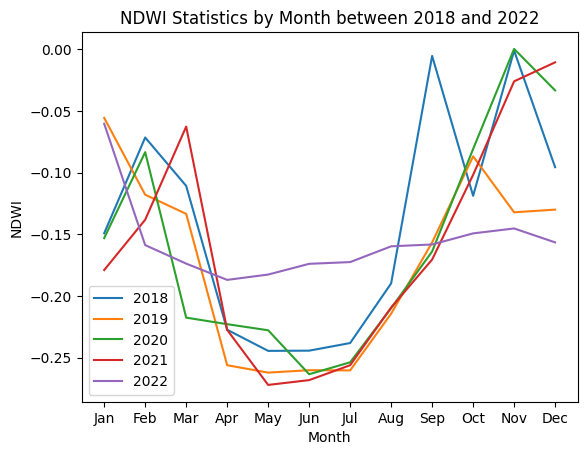

In [27]:
# Plot the divided lists
i=2018
for sublist in years_NDWI:
    plt.plot(x, sublist, label=str(i))
    i+=1

# Customize the plot
plt.xlabel('Month')
plt.ylabel('NDWI')
plt.title('NDWI Statistics by Month between 2018 and 2022')
plt.xticks(x, month_labels)
plt.legend()

# Display the plot
plt.show()

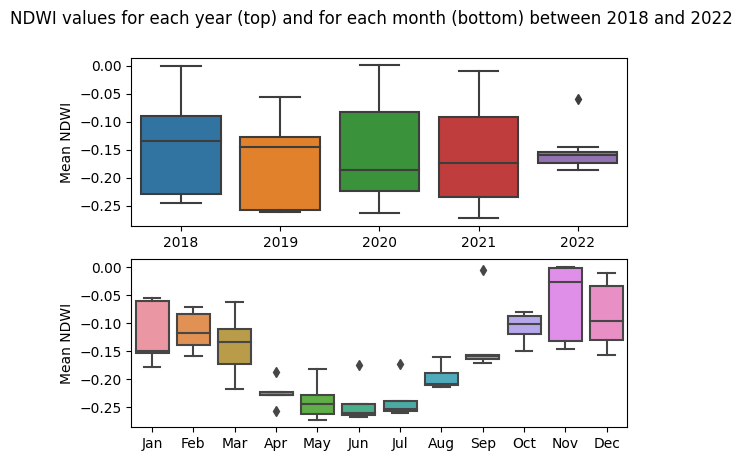

In [28]:
# Create the Dataframe
data_NDWI = pd.DataFrame({'Year': years,
                          'Month': labels_repeated,
                          'Mean NDVI': mean_ndvi,
                          'Mean NDWI': mean_ndwi})

#define dimensions of subplots (rows, columns)
fig, axes = plt.subplots(2, 1)

#Create boxplot for year and month
sns.boxplot(data=data_NDWI, x='Year', y='Mean NDWI', ax=axes[0])
sns.boxplot(data=data_NDWI, x='Month', y='Mean NDWI', ax=axes[1])

# Disable x axis labels and add title
axes[0].set_xlabel('')
axes[1].set_xlabel('')
plt.suptitle('NDWI values for each year (top) and for each month (bottom) between 2018 and 2022', ha='center')

# Display the plot
plt.show()

In [29]:
# Execute tests for years
mean_difference(years_NDWI)

All groups do not follow a Normal distribution
P-value for Kruskal test is : 0.9350467369463166
No significant difference between the groups


In [30]:
# Execute tests for months
mean_difference(months_NDWI)

All groups do not follow a Normal distribution
P-value for Kruskal test is : 5.882428158354751e-06
Significant difference between at least 2 groups
Dunn's posthoc test:
          1         2         3         4         5         6         7    
1   1.000000  0.896454  0.812484  0.054027  0.024412  0.022309  0.033405  \
2   0.896454  1.000000  0.739929  0.039070  0.017395  0.016470  0.023299   
3   0.812484  0.739929  1.000000  0.118118  0.053626  0.048087  0.070222   
4   0.054027  0.039070  0.118118  1.000000  0.812484  0.776966  0.879169   
5   0.024412  0.017395  0.053626  0.812484  1.000000  0.956757  0.897751   
6   0.022309  0.016470  0.048087  0.776966  0.956757  1.000000  0.895294   
7   0.033405  0.023299  0.070222  0.879169  0.897751  0.895294  1.000000   
8   0.170800  0.118118  0.343077  0.741018  0.511114  0.467837  0.590575   
9   0.812484  0.739929  1.000000  0.118118  0.053626  0.048087  0.070222   
10  0.830494  0.897751  0.639776  0.028595  0.013515  0.012630  0.01739

## Retrieve weather data 

In [31]:
# Set time period
start_global = datetime(2018, 1, 1)
end_global = datetime(2022, 12, 31)

start_ombro = datetime(2001, 1, 1)
end_ombro = datetime(2021, 12, 31)

# Create Point for Samos
location = Point(37.69453163651369, 26.971765416215106)

# Get monthly data 
data_global= Monthly(location, start_global, end_global)
data_global= data_global.fetch()

data = Monthly(location, start_ombro, end_ombro)
data = data.fetch()

# Setting mean for each month
monthly_mean_temp = data['tavg'].groupby(data.index.month).mean()
monthly_mean_prcp = data['prcp'].groupby(data.index.month).mean()

print(data_global)

            tavg  tmin  tmax   prcp  wspd    pres  tsun
time                                                   
2018-01-01  11.0   NaN   NaN  231.9   NaN     NaN   NaN
2018-02-01  13.6   NaN   NaN    NaN   NaN     NaN   NaN
2018-03-01  15.8   NaN   NaN   17.0   NaN     NaN   NaN
2018-04-01  19.4   NaN   NaN    0.0   NaN     NaN   NaN
2018-05-01  23.8   NaN   NaN    7.1   NaN     NaN   NaN
2018-06-01  26.0   NaN   NaN   12.7   NaN     NaN   NaN
2018-07-01  29.4   NaN   NaN    0.0   NaN     NaN   NaN
2018-08-01  28.9  24.4  33.2    0.0  13.4  1008.5   NaN
2018-09-01  26.0  21.4  29.9    NaN  13.8  1012.8   NaN
2018-10-01  20.4  16.5  24.2   11.2  10.6  1016.7   NaN
2018-11-01  16.9  13.7  19.9  122.6  13.9  1017.2   NaN
2018-12-01  11.3   7.7  14.0  132.3  13.9  1017.2   NaN
2019-01-01  10.5   8.5  13.0  290.0  17.4  1010.5   NaN
2019-02-01  11.7   8.8  14.9   57.0  14.3  1017.1   NaN
2019-03-01  14.1  10.4  17.6   34.0   NaN  1015.1   NaN
2019-04-01  16.4  12.8  19.8   32.0  11.6  1014.

### Ombrothermic diagram to see hydric stress

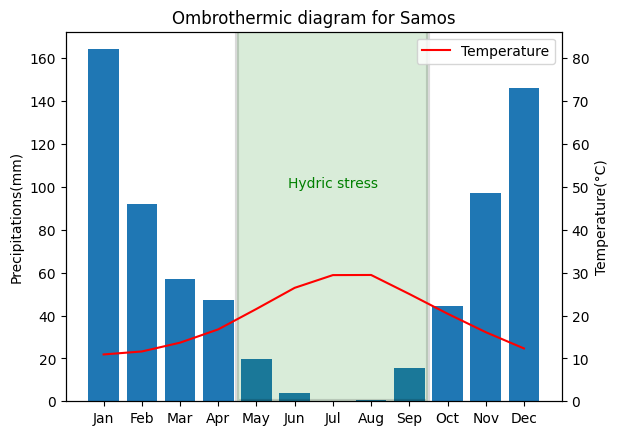

In [32]:
# Plot temperature and precipitations for each month 

# Putting 2 y-axis
fig, ax1 = plt.subplots()
ax2=ax1.twinx()

# Plotting precipitations in barplot
ax1.bar(x, monthly_mean_prcp, label='Precipitations')
ax1.set_ylabel('Precipitations(mm)')

# Plotting temperature in plot
ax2.plot(x, monthly_mean_temp, label='Temperature', color = 'r')
ax2.set_ylabel('Temperature(°C)')

# Getting y limits for precipitations to have P=2T
a= ax1.get_ylim()
ax2.set_ylim(a[0]/2,a[1]/2)

# Add rectangle
ax1.add_patch(
patches.Rectangle(
(4.5, 0), # (x,y)
5, # width
180, # height
alpha=0.15, facecolor="green", edgecolor="black", linewidth=3, linestyle='solid')
)
# Annotation
plt.text(7, 50, 'Hydric stress', fontsize=10,ha='center', color = 'green')

# Naming the graph
plt.xlabel('Month')
plt.title('Ombrothermic diagram for Samos')
plt.xticks(x, month_labels)

plt.legend()

plt.show()

## Tests for correlation between precipitations and NDWI/NDVI

In [33]:
# Dataframe with NDVI and NDWI
data_t = {
    'Year': years,
    'Month': labels_repeated,
    'Tavg': data_global['tavg'],
    'Tmin': data_global['tmin'],
    'Tmax': data_global['tmax'],
    'Prcp': data_global['prcp'],
    'Wspd': data_global['wspd'],
    'Pres': data_global['pres'],
    'Tsun': data_global['tsun'],
    'Mean NDWI': mean_ndwi,
    'Mean NDVI': mean_ndvi,
}
data_t = pd.DataFrame(data_t)


In [34]:
# Delete rows in which Precipitations equal NaN
data_wo_na=data_t.dropna(subset=['Prcp'], inplace=False)

In [35]:
def correlation_tests(entry1,entry2,entry3):
    # Set parameters for tests
    X_NDVI= entry1
    X_NDWI= entry2
    Y= entry3

    # Shapiro test for normality test
    sh_NDVI = shapiro(X_NDVI)
    sh_NDWI = shapiro(X_NDWI)
    sh_pr= shapiro(Y)

    # Validation tests for NDVI 
    if sh_NDVI[1]<0.05 and sh_pr[1]<0.05:
        stat, p = sp.stats.bartlett(X_NDVI,Y)
        if p>0.05:
            rho_NDVI, p_NDVI = pearsonr(X_NDVI, Y)
            print('Pearson test performed')
        else:
            rho_NDVI, p_NDVI = spearmanr(X_NDVI, Y)
            print('Spearman test performed')
    else:
        rho_NDVI, p_NDVI = spearmanr(X_NDVI, Y)
        print('Spearman test performed')

    # Print Rho and p-value
    print('Rho for '+ str(entry1.name) +' is equal to:',rho_NDVI)
    print('p-value for '+ str(entry1.name) +' is:',p_NDVI)

    # Tell if it is significant or not for NDVI
    if p_NDVI<0.05:
        print('The correlation between {} and {} is statistically significant'.format(entry1.name,entry3.name))
    else:
        print('The correlation between {} and {} is not statistically significant'.format(entry1.name,entry3.name))
    print('\n')    

    # Validation tests for NDWI 
    if sh_NDWI[1]<0.05 and sh_pr[1]<0.05:
        stat, p = sp.stats.bartlett(X_NDWI,Y)
        if p>0.05:
            rho_NDWI, p_NDWI = pearsonr(X_NDWI, Y)
            print('Pearson test performed')
        else:
            rho_NDWI, p_NDWI = spearmanr(X_NDWI, Y)
            print('Spearman test performed')
    else:
        rho_NDWI, p_NDWI = spearmanr(X_NDWI, Y)
        print('Spearman test performed')

    # Print Rho and p-value
    print('Rho for '+ str(entry2.name) +' is equal to:',rho_NDWI)
    print('p-value for '+ str(entry2.name) +' is:',p_NDWI)

    # Tell if it is significant or not for NDWI
    if p_NDWI<0.05:
        print('The correlation between {} and {} is statistically significant'.format(entry2.name,entry3.name))
    else:
        print('The correlation between {} and {} is not statistically significant'.format(entry2.name,entry3.name))
    
    return(rho_NDVI,rho_NDWI)


In [36]:
# Test correlation between NDVI/NDWI and precipitations
rho_NDVI, rho_NDWI = correlation_tests(data_wo_na['Mean NDVI'],data_wo_na['Mean NDWI'],data_wo_na['Prcp'])

Spearman test performed
Rho for Mean NDVI is equal to: 0.28082182623679924
p-value for Mean NDVI is: 0.0437385210632885
The correlation between Mean NDVI and Prcp is statistically significant


Spearman test performed
Rho for Mean NDWI is equal to: 0.45729148900816224
p-value for Mean NDWI is: 0.0006539569150698319
The correlation between Mean NDWI and Prcp is statistically significant


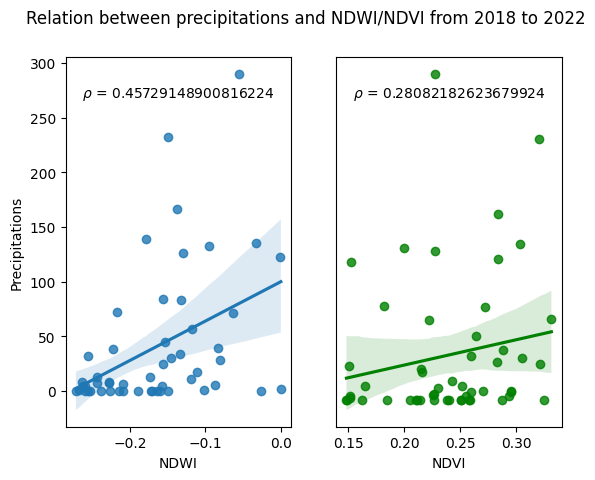

In [37]:
#define dimensions of subplots (rows, columns)
fig, axes = plt.subplots(1, 2)

X_NDWI=data_t['Mean NDWI']
X_NDVI=data_t['Mean NDVI']
Y=data_t['Prcp']
#create chart in each subplot
sns.regplot(data= data_wo_na, x = X_NDWI, y = Y, ax=axes[0])
sns.regplot(data= data_wo_na, x = X_NDVI, y = Y, ax=axes[1], color = 'g')

# Set labels for y and x axis
axes[0].set_ylabel('Precipitations')
axes[0].set_xlabel('NDWI')
axes[1].set_ylabel('')
axes[1].set_yticks([])
axes[1].set_xlabel('NDVI')

# Add annotation to the first subplot
axes[0].text(0.5, 0.9, r"$\rho$ = "+ str(rho_NDWI), ha='center', va='center', transform=axes[0].transAxes)

# Add annotation to the second subplot
axes[1].text(0.5, 0.9, r"$\rho$ = "+ str(rho_NDVI), ha='center', va='center', transform=axes[1].transAxes)

# Set the suptitle to center
plt.suptitle('Relation between precipitations and NDWI/NDVI from 2018 to 2022', ha='center')
plt.show()

In [38]:
# Correlation tests for NDWI/NDVI and temperature
rho_NDVI, rho_NDWI = correlation_tests(data_wo_na['Mean NDVI'],data_wo_na['Mean NDWI'],data_wo_na['Tavg'])

Spearman test performed
Rho for Mean NDVI is equal to: -0.3249023500772107
p-value for Mean NDVI is: 0.018768270740406913
The correlation between Mean NDVI and Tavg is statistically significant


Spearman test performed
Rho for Mean NDWI is equal to: -0.5691660798291224
p-value for Mean NDWI is: 1.0678524369782328e-05
The correlation between Mean NDWI and Tavg is statistically significant


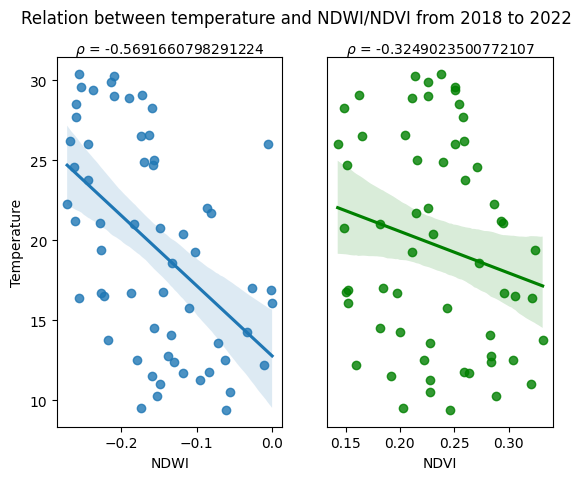

In [39]:
#define dimensions of subplots (rows, columns)
fig, axes = plt.subplots(1, 2)
Y=data_t['Tavg']
#create chart in each subplot
sns.regplot(data= data_wo_na, x = X_NDWI, y = Y, ax=axes[0])
sns.regplot(data= data_wo_na, x = X_NDVI, y = Y, ax=axes[1], color = 'g')

# Set labels for y and x axis
axes[0].set_ylabel('Temperature')
axes[0].set_xlabel('NDWI')
axes[1].set_ylabel('')
axes[1].set_yticks([])
axes[1].set_xlabel('NDVI')

# Add annotation to the first subplot
axes[0].text(0.5, 1.02, r"$\rho$ = "+ str(rho_NDWI), ha='center', va='center', transform=axes[0].transAxes)

# Add annotation to the second subplot
axes[1].text(0.5, 1.02, r"$\rho$ = "+ str(rho_NDVI), ha='center', va='center', transform=axes[1].transAxes)

# Set the suptitle to center
plt.suptitle('Relation between temperature and NDWI/NDVI from 2018 to 2022', ha='center')
plt.show()

# Water extent calculation

## NDWI supervised classification

In [40]:
# Import ground truth points
sampling_points = ee.FeatureCollection('projects/archipelagos-michel-project/assets/Data_wetland_1106')

# Replace other than Water (ClassId = 0) by Other (ClassId = 1)
def replaceNonZero(feature):
    classId = feature.getNumber('ClassId')
    newClassId = ee.Algorithms.If(classId.neq(0), 1, classId)
    return feature.set('ClassId', newClassId)

# Apply the function to the feature
NDWI_gt = sampling_points.map(replaceNonZero)

In [41]:
# Import Ground truth data
features = NDWI_gt
# Define the desired percentage range for training data
target_percentage_min = 0.65
target_percentage_max = 0.75

# Initialize variables
seed = 0
training_percentage = 0
validation_percentage = 1

# Define the percentage value for splitting
percentage = 0.7  
    
# Iterate until the desired percentage range is achieved
while (
    training_percentage < target_percentage_min or
    training_percentage > target_percentage_max
):
    # Update the seed value
    seed += 1
    feature_random = features.randomColumn('random', seed)

    
    # Split the feature collection into training and validation datasets
    training = feature_random.filter(ee.Filter.lte('random', percentage))
    validation = feature_random.filter(ee.Filter.gt('random', percentage))

    # Calculate the current training and validation percentages
    total_count = training.size().add(validation.size())
    training_percentage = training.size().divide(total_count).getInfo()

validation_percentage = validation.size().divide(total_count).getInfo()

# Print the number of features in each dataset
print('Number of training features:', training.size().getInfo())
print('Number of validation features:', validation.size().getInfo())
print('Percentage of training features:', training_percentage * 100, '%')
print('Seed number:', seed)


Number of training features: 69
Number of validation features: 24
Percentage of training features: 74.19354838709677 %
Seed number: 2


In [42]:
# Training with May 2023 data
image_2023 = dataset_image.median()
image_2023 = image_2023.normalizedDifference(['B3', 'B8'])

# Create a dictionary to map the old band names to the new ones (if needed)
#band_name_mapping = {'nd': 'B8'}

# Update the band names using the select function and the mapping dictionary
#image_2023 = image_2023.select(list(band_name_mapping.keys()), list(band_name_mapping.values()))

#Load NDWI values for each point
trainingData_2023 = image_2023.sampleRegions(collection= training, properties= ['ClassId'],scale= 10)
validationData_2023 = image_2023.sampleRegions(collection= validation, properties= ['ClassId'],scale= 10)

#Train a Random Forest classifier
classifier_2023 = ee.Classifier.smileRandomForest(10).train(trainingData_2023, 'ClassId', ['nd'])
classified_2023 = image_2023.classify(classifier_2023)

#Classify validation dataset
validationClassification_2023 = validationData_2023.classify(classifier_2023)
#print(image_2023.bandNames().getInfo())

# Set the visualization parameters
vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['blue','grey']
}

# Add classified 2023 image layer
Map.addLayer(classified_2023, vis_params, 'Classif May 2023')
Map

Map(bottom=3244669.0, center=[37.707147, 27.009654], controls=(WidgetControl(options=['position', 'transparent…

In [43]:
#Error matrix and overall accuracy
def createMatrix(data):
    trainAccuracy = data.errorMatrix("ClassId", "classification")
    print('Resubstitution error matrix: ', trainAccuracy.getInfo())
    print('Training overall accuracy: ', trainAccuracy.accuracy().getInfo())

createMatrix(validationClassification_2023)

Resubstitution error matrix:  [[7, 0], [1, 16]]
Training overall accuracy:  0.9583333333333334


In [44]:
# Import Psili Ammos geometry
ps_am = ee.FeatureCollection('projects/archipelagos-michel-project/assets/ps_am')

# Total area calculation 
PsiliArea = ps_am.geometry().area()
PsiliAreaSqm = ee.Number(PsiliArea)
print(PsiliAreaSqm.getInfo())

295320.69384325505


## Apply classification on NDWI for a whole year

In [45]:
# Initialize variable and lists
i = 0
water_extent=[]
percentage_area=[]
result_images=[]

# Loop for each NDWI image
for month in NDWI_month:
    # Apply classifier for each image
    input = month
    classified = input.classify(classifier_2023)
    
    # Water mask to exclude land for water extent calculation
    water_mask = classified.lt(1)
    water_mask = water_mask.clip(ps_am)
    
    # Store NDWI images for considered area into a list
    result_images.append(water_mask)
    
    # Water extent calculation in Psili Ammos
    area = water_mask.multiply(ee.Image.pixelArea())
    stats = area.reduceRegion(reducer= ee.Reducer.sum(),geometry= ps_am,scale= 10)
    
    # Display water surface and percentage
    water_area = ee.Number(stats.get('classification'))
    water_extent.append(water_area.divide(1e6).getInfo())
    percentage_area.append(water_area.getInfo()/PsiliAreaSqm.getInfo()*100)
    
    # Display informations
    #print(month_labels[i])
    #print('Psili Ammos water area:',water_area.divide(1e6).getInfo(), 'km²')
    #print('Psili Ammos total area:', PsiliAreaSqm.getInfo(), 'm²')
    #print('Water proportion in the area:',water_area.getInfo()/PsiliAreaSqm.getInfo()*100, '%')
    #print('\n')
    
    # Increment for month display
    i += 1
   
print('Water extent:', water_extent, '\n')
print('Water percentage:',percentage_area)

Water extent: [0.1133298422164618, 0.11227681821253162, 0.11369723424658684, 0.09856645271414964, 0.08596985563519047, 0.07533176168012433, 0.07851303477436142, 0.04338871895348044, 0.01957180605507645, 0, 0, 0.10475135106401631, 0.10969950133188287, 0.1052636541581397, 0.10738995230682971, 0.09309918540422027, 0.08774585826421999, 0.062110912428702564, 0.015834971359133254, 0.00012667940377628103, 7.309628484389361e-05, 0.05220564060974121, 0.050152145065307616, 0.08672232097033333, 0.1084925500610651, 0.1114603575621362, 0.11123176623954026, 0.11003093690694173, 0.10487647633269068, 0.08262958490486892, 0.060088804503736305, 0.053486651948876474, 0.030340715560972925, 0.0007461291721418793, 0, 0.09903751714740829, 0.09861534309524836, 0.10438629079084209, 0.10751509794969746, 0.10229547224159988, 0.08555229530519971, 0.0562855525909723, 0.0374680064439063, 0.013805065046003755, 0.0031747070280187272, 0.08099358305319992, 0.08318148017691818, 0.1018073545015223, 0.10495169600904876, 0

In [47]:
# Create new dataset with water extent and percentage
data_water = pd.DataFrame({
    'Year': years,
    'Month': labels_repeated,
    'Tavg': data_global['tavg'],
    'Tmin': data_global['tmin'],
    'Tmax': data_global['tmax'],
    'Prcp': data_global['prcp'],
    'Wspd': data_global['wspd'],
    'Pres': data_global['pres'],
    'Tsun': data_global['tsun'],
    'Mean NDWI': mean_ndwi,
    'Mean NDVI': mean_ndvi,
    "Water extent": water_extent,
    "Water percentage": percentage_area
})


## Plots for water extent

In [48]:
# Create lists for years and month on water extent
years_water, months_water = new_lists(water_extent)

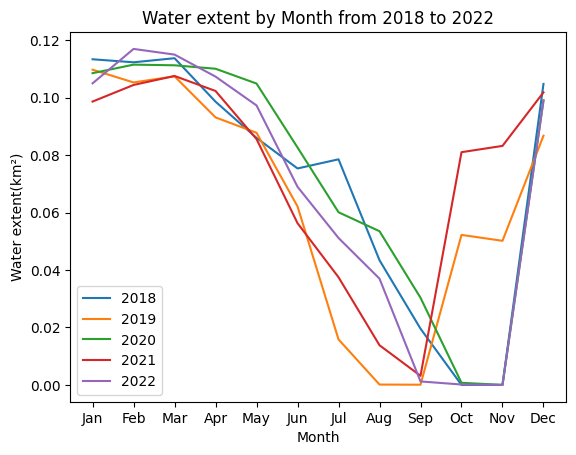

In [49]:
x= range(1,13)

# Plot the divided lists
i=2018
for sublist in years_water:
    plt.plot(x, sublist, label=str(i))
    i+=1

# Customize the plot
plt.xlabel('Month')
plt.ylabel('Water extent(km²)')
plt.title('Water extent by Month from 2018 to 2022')
plt.xticks(x, month_labels)
plt.legend()

# Display the plot
plt.show()


In [50]:
# Delete rows in which Precipitations equal NaN
data_water_wo_na=data_water.dropna(subset=['Prcp'], inplace=False)

In [51]:
# Test for correlation
rho_prcp, rho_tavg=correlation_tests(data_water_wo_na['Prcp'],data_water_wo_na['Tavg'],data_water_wo_na['Water extent'])

Spearman test performed
Rho for Prcp is equal to: 0.5223239328206664
p-value for Prcp is: 7.134066640963064e-05
The correlation between Prcp and Water extent is statistically significant


Spearman test performed
Rho for Tavg is equal to: -0.6553674741809056
p-value for Tavg is: 1.3476637705203866e-07
The correlation between Tavg and Water extent is statistically significant


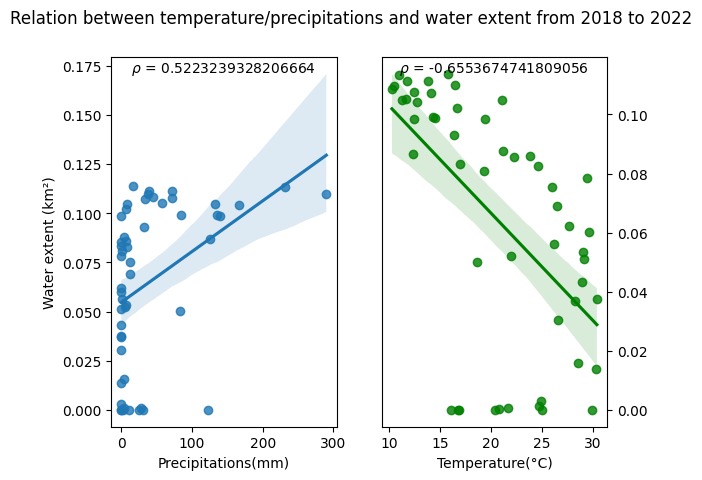

In [52]:
X_prcp=data_water_wo_na['Prcp']
X_tavg= data_water_wo_na['Tavg']
Y= data_water_wo_na['Water extent']
#define dimensions of subplots (rows, columns)
fig, axes = plt.subplots(1, 2)

#create chart in each subplot
sns.regplot(data= data_t, x = X_prcp, y = Y, ax=axes[0])
sns.regplot(data= data_t, x = X_tavg, y = Y, ax=axes[1], color = 'g')

# Set labels for y and x axis
axes[0].set_ylabel('Water extent (km²)')
axes[0].set_xlabel('Precipitations(mm)')
axes[1].set_ylabel('')
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
#axes[1].set_yticks([])
axes[1].set_xlabel('Temperature(°C)')

# Add annotation to the first subplot
axes[0].text(0.5, 0.97, r"$\rho$ = "+ str(rho_prcp), ha='center', va='center', transform=axes[0].transAxes)

# Add annotation to the second subplot
axes[1].text(0.5, 0.97, r"$\rho$ = "+ str(rho_tavg), ha='center', va='center', transform=axes[1].transAxes)

# Set the suptitle to center
plt.suptitle('Relation between temperature/precipitations and water extent from 2018 to 2022', ha='center')
plt.show()

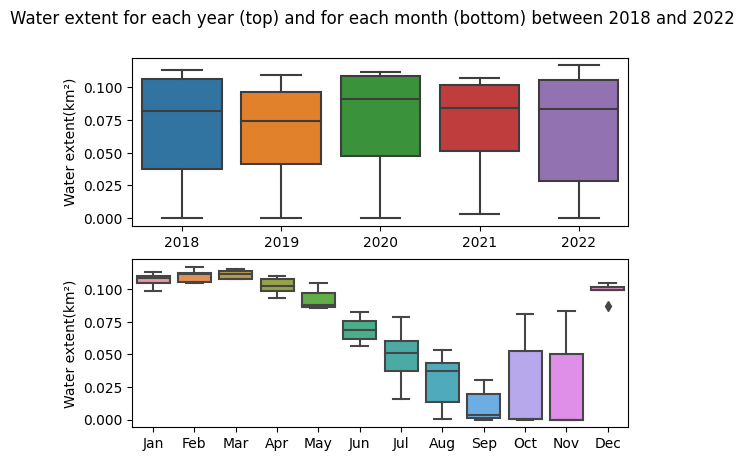

In [53]:
#define dimensions of subplots (rows, columns)
fig, axes = plt.subplots(2, 1)

#Create boxplot for year and month
sns.boxplot(data=data_water, x='Year', y='Water extent', ax=axes[0])
sns.boxplot(data=data_water, x='Month', y='Water extent', ax=axes[1])

# Disable x axis labels and add title
axes[0].set_xlabel('')
axes[0].set_ylabel('Water extent(km²)')
axes[1].set_xlabel('')
axes[1].set_ylabel('Water extent(km²)')
plt.suptitle('Water extent for each year (top) and for each month (bottom) between 2018 and 2022', ha='center')

# Display the plot
plt.show()

In [54]:
# Test for years
mean_difference(years_water)

All groups do not follow a Normal distribution
P-value for Kruskal test is : 0.9731220514342724
No significant difference between the groups


In [55]:
# Test for months
mean_difference(months_water)

All groups do not follow a Normal distribution
P-value for Kruskal test is : 3.528852938886655e-07
Significant difference between at least 2 groups
Dunn's posthoc test:
          1         2         3         4         5         6         7    
1   1.000000  0.834026  0.751663  0.732708  0.373517  0.074233  0.028478  \
2   0.834026  1.000000  0.897744  0.545320  0.250508  0.041612  0.013114   
3   0.751663  0.897744  1.000000  0.468270  0.191447  0.028659  0.008793   
4   0.732708  0.545320  0.468270  1.000000  0.650756  0.207790  0.074233   
5   0.373517  0.250508  0.191447  0.650756  1.000000  0.496987  0.261142   
6   0.074233  0.041612  0.028659  0.207790  0.496987  1.000000  0.732708   
7   0.028478  0.013114  0.008793  0.074233  0.261142  0.732708  1.000000   
8   0.008793  0.003981  0.003220  0.028537  0.107522  0.465834  0.749878   
9   0.003913  0.002712  0.002712  0.013114  0.054483  0.311142  0.545320   
10  0.007138  0.003643  0.002712  0.025636  0.089616  0.413396  0.71366

### Precipitations statistics

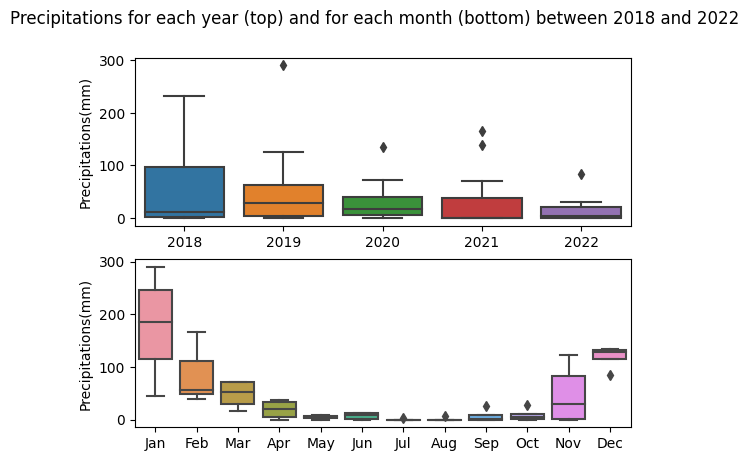

In [57]:
#define dimensions of subplots (rows, columns)
fig, axes = plt.subplots(2, 1)

#Create boxplot for year and month
sns.boxplot(data=data_water, x='Year', y='Prcp', ax=axes[0])
sns.boxplot(data=data_water, x='Month', y='Prcp', ax=axes[1])

# Disable x axis labels and add title
axes[0].set_xlabel('')
axes[0].set_ylabel('Precipitations(mm)')
axes[1].set_xlabel('')
axes[1].set_ylabel('Precipitations(mm)')
plt.suptitle('Precipitations for each year (top) and for each month (bottom) between 2018 and 2022', ha='center')

# Display the plot
plt.show()

In [58]:
# Create lists for years and month
years_prcp, months_prcp = new_lists(data_water['Prcp'])

# Clear NaN values from nested list
years_prcp = [[x for x in sublist if not math.isnan(x)] for sublist in years_prcp]
months_prcp = [[x for x in sublist if not math.isnan(x)] for sublist in months_prcp]

In [59]:
# Test for years
mean_difference(years_prcp)

All groups follow a Normal distribution
The groups have equal variances (homoscedastic).
P-value for ANOVA test is : 0.7179195849243158


In [60]:
# Test for months
mean_difference(months_prcp)

All groups do not follow a Normal distribution
P-value for Kruskal test is : 0.00020816146175140746
Significant difference between at least 2 groups
Dunn's posthoc test:
          1         2         3         4         5         6         7    
1   1.000000  0.773900  0.523186  0.144239  0.049262  0.052545  0.007398  \
2   0.773900  1.000000  0.773900  0.289929  0.148684  0.155055  0.037372   
3   0.523186  0.773900  1.000000  0.457628  0.228819  0.261340  0.049262   
4   0.144239  0.289929  0.457628  1.000000  0.704345  0.785656  0.259589   
5   0.049262  0.148684  0.228819  0.704345  1.000000  0.875812  0.532204   
6   0.052545  0.155055  0.261340  0.785656  0.875812  1.000000  0.412622   
7   0.007398  0.037372  0.049262  0.259589  0.532204  0.412622  1.000000   
8   0.007398  0.037372  0.049262  0.279045  0.573646  0.426143  0.955547   
9   0.037372  0.101840  0.153371  0.573646  0.875812  0.773900  0.645389   
10  0.049262  0.153371  0.252926  0.773900  0.902703  0.957887  0.4225

### Temperature statistics

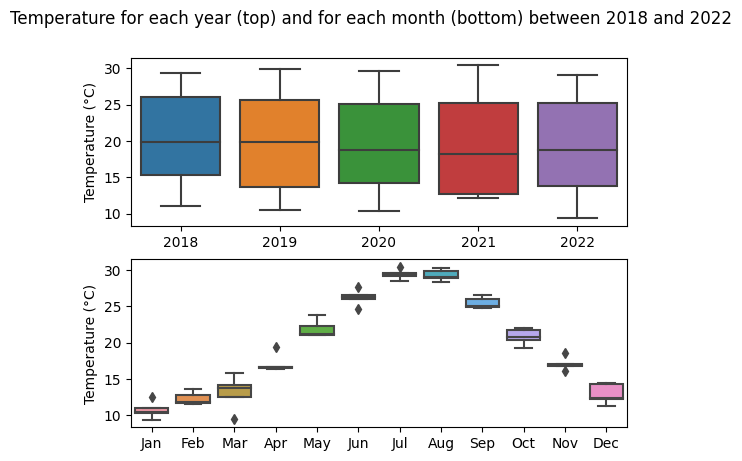

In [61]:
#define dimensions of subplots (rows, columns)
fig, axes = plt.subplots(2, 1)

#Create boxplot for year and month
sns.boxplot(data=data_water, x='Year', y='Tavg', ax=axes[0])
sns.boxplot(data=data_water, x='Month', y='Tavg', ax=axes[1])

# Disable x axis labels and add title
axes[0].set_xlabel('')
axes[0].set_ylabel('Temperature (°C)')
axes[1].set_xlabel('')
axes[1].set_ylabel('Temperature (°C)')
plt.suptitle('Temperature for each year (top) and for each month (bottom) between 2018 and 2022', ha='center')

# Display the plot
plt.show()

In [62]:
# Create lists for years and month on water extent
years_tavg, months_tavg = new_lists(data_water['Tavg'])

# Test for years
mean_difference(years_tavg)

All groups do not follow a Normal distribution
P-value for Kruskal test is : 0.9937215625055749
No significant difference between the groups


In [63]:
# Test for months
mean_difference(months_tavg)

All groups do not follow a Normal distribution
P-value for Kruskal test is : 4.1208900960787384e-08
Significant difference between at least 2 groups
Dunn's posthoc test:
          1         2         3         4         5         6         7    
1   1.000000  0.691889  0.536324  0.138963  0.016926  0.001403  0.000206  \
2   0.691889  1.000000  0.865437  0.317315  0.050750  0.007369  0.000869   
3   0.536324  0.865437  1.000000  0.427251  0.088580  0.014053  0.001254   
4   0.138963  0.317315  0.427251  1.000000  0.418521  0.121906  0.018351   
5   0.016926  0.050750  0.088580  0.418521  1.000000  0.494644  0.150604   
6   0.001403  0.007369  0.014053  0.121906  0.494644  1.000000  0.491528   
7   0.000206  0.000869  0.001254  0.018351  0.150604  0.491528  1.000000   
8   0.000206  0.000960  0.001403  0.022940  0.172624  0.526626  0.942133   
9   0.002222  0.011105  0.018351  0.140456  0.552700  0.926953  0.430070   
10  0.027359  0.088580  0.130855  0.516985  0.865437  0.404011  0.1133

## Plot temperature, rainfall and water extent

In [64]:
# Mean per month
monthly_mean_water = data_water['Water extent'].groupby(data_water.index.month).mean()
monthly_mean_tavg = data_water['Tavg'].groupby(data_water.index.month).mean()
monthly_mean_precipitations = data_water['Prcp'].groupby(data_water.index.month).mean()


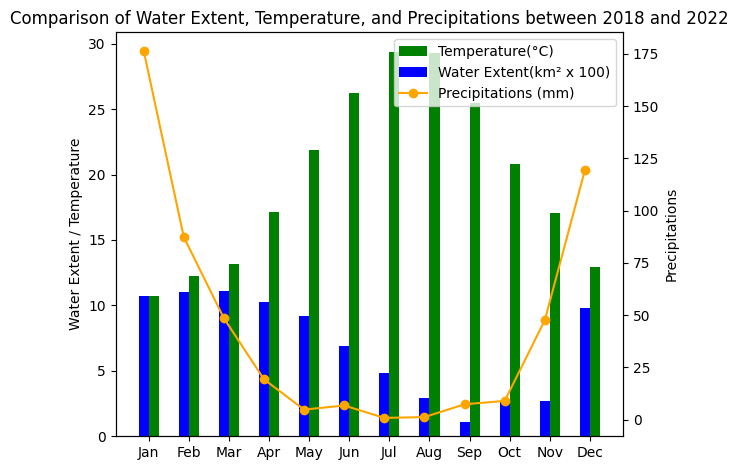

In [65]:
# Multiply water extent by 100
scaled_water_extent = [val * 100 for val in monthly_mean_water]

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = np.arange(len(month_labels))
r2 = [x + bar_width for x in r1]

# Create a figure and axes objects
fig, ax1 = plt.subplots()

# Plot the water extent as a bar chart
ax1.bar(r2, monthly_mean_tavg, color='green', width=bar_width, label='Temperature(°C)')
ax1.bar(r1, scaled_water_extent, color='blue', width=bar_width, label='Water Extent(km² x 100)')


# Customize the x-axis labels and ticks
plt.xticks([r + bar_width/2 for r in range(len(month_labels))], month_labels)

# Set the y-axis label for the first axis
ax1.set_ylabel('Water Extent / Temperature')

# Create a second axis for the rainfall as a line chart
ax2 = ax1.twinx()
ax2.plot(r1, monthly_mean_precipitations, color='orange', marker='o', label='Precipitations (mm)')

# Set the y-axis label for the second axis
ax2.set_ylabel('Precipitations')

# Set the title
plt.title('Comparison of Water Extent, Temperature, and Precipitations between 2018 and 2022')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Adjust the layout to prevent overlapping of labels
plt.tight_layout()

# Show the plot
plt.show()